In [2]:
import seaborn as sns
from adaptive_CI.compute import collect
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
from time import time
from glob import glob
import scipy.stats as stats
from IPython.display import display, HTML
from adaptive_CI.saving import *
import  pickle
import warnings
from pickle import UnpicklingError
import copy
from itertools import compress
import scipy.stats as stats
from plot_utils import *

sns.set_context("notebook", font_scale=1.4)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
def plot_contrast(df,
                  row_order=['nosignal', 'lowSNR', 'highSNR'],
                  col_order=['mse', 'bias', 'CI_width', '90% coverage of t-stat'],
                  col_names=['RMSE', 'bias', 'Confidence Interval Radius', '90% coverage'],
                  hue_order=['uniform', 'propscore', 'lvdl', 'two_point', 'two_point_old', 'bernstein'], 
                  labels=['uniform', 'propscore', 'constant', 'two-point (NEW)', 'two-point (OLD)', 'bernstein'],
                  name=None):
    """
    Plot RMSE, bias and 90% coverage of t-statisitcs in cases of no-signal and high-SNR across different weighting schemes.
    """
    palette = sns.color_palette("muted")[:len(hue_order)]
    g = sns.catplot(x="T",
                    y="value",
                    col="statistic",
                    col_order=col_order,
                    row="dgp",
                    row_order=row_order,
                    hue='method',
                    hue_order=hue_order,
                    palette=palette,
                    kind="point",
                    sharex=False,
                    sharey=False,
                    legend=False,
                    legend_out=True,
                    margin_titles=True,
                    data=df)

    # Plot ROOT mse
    for i, dgp in enumerate(row_order): 
        g.axes[i, 0].clear()
        sns.pointplot(x='T',
                      y="value",
                      hue='method',
                      hue_order=hue_order,
                      palette=palette,
                      ax=g.axes[i, 0],
                      data=df.query(f"statistic=='mse' & dgp=='{dgp}'"),
                      estimator=lambda x: np.sqrt(np.mean(x)),
                      markers="")
        g.axes[i, 0].get_legend().remove()
    g.axes[0, 0].set_xlabel("")
    g.axes[0, 0].set_ylabel("")


    # Add row and column names
    g.row_names = ['NO SIGNAL', 'LOW-SIGNAL', 'HIGH SNR']
    g.col_names = col_names

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="")
    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    
    for ax in g.axes[:, 1]:
        ax.axhline(0, color="black", linestyle='--')
        
    for ax in g.axes[:, -1]:
        ax.axhline(0.90, color="black", linestyle='--')

    g.fig.tight_layout()

    # Add legend
    handles, ls = g._legend_data.values(), g._legend_data.keys()
    label_dict = dict(zip(hue_order, labels))
    labels = [label_dict[k] for k in ls]
    g.fig.legend(labels=labels, frameon=False,
                 handles=handles, loc='lower center',
                 ncol=len(labels), bbox_to_anchor=(0.5, 0.0))

    g.set_xlabels("")
    g.set_ylabels("")
    g.fig.tight_layout()

    g.fig.subplots_adjust(bottom=0.1)

    if name is not None:
        g.fig.savefig(f'figures/{name}.pdf', bbox_inches='tight')
    plt.show()


In [4]:
def plot_arm_values(df,
                   col_order=['mse', 'bias', 'CI_width', '90% coverage of t-stat'],
                   row_order=[2, 0],
                   hue='method',
                   hue_order=['uniform', 'propscore', 'lvdl', 'two_point', 'two_point_old', 'bernstein'], 
                   labels=['uniform', 'propscore', 'constant allocation rate', 'two-point (NEW)', 'two-point (OLD)', 'bernstein'],
                   noise_func='uniform', 
                   name=None):
    """
    Plot converged RMSE and bias of bad arm and good arm across different weighting schemes.
    """
    palette = sns.color_palette("muted")[:len(hue_order)]

    order = ['nosignal', 'lowSNR', f'highSNR']
    order_name = ['NO SIGNAL', 'LOW SNR', 'HIGH SNR']
    g = sns.catplot(x="dgp",
                    y="value",
                    order=order,
                    hue='method',
                    hue_order=hue_order,
                    palette=palette,
                    col="statistic",
                    col_order=col_order,
                    row="policy",
                    row_order=row_order,
                    kind="point",
                    sharex=False,
                    sharey=False, #'col',
                    legend=False,
                    legend_out=True,
                    margin_titles=True,
                    data=df)

    # Plot RMSE of bad arm based on MSE
    for i, arm in enumerate(row_order):
        g.axes[i, 0].clear()
        sns.pointplot(x='dgp',
                      y="value",
                      order=order,
                      hue='method',
                      hue_order=hue_order,
                      palette=palette,
                      ax=g.axes[i, 0],
                      data=df.query(f"policy=={arm} & statistic=='mse'"),
                      estimator=lambda x: np.sqrt(np.mean(x)),
                      )
        g.axes[i, 0].get_legend().remove()
        g.axes[i, 0].set_xlabel("")
        g.axes[i, 0].set_ylabel("")


    # Add row and column names
    g.col_names = ['RMSE', 'Bias', 'Confidence Interval Radius', '90% coverage']
    g.row_names = ['GOOD ARM', 'BAD ARM']

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="")
    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    # Set xticklabels to be [NO SIGNAL, LOW SIGNAL and HIGH SIGNAL]
    for ax in g.axes.flat:
        ax.set_xticklabels(order_name)
        
    for ax in g.axes[:, 1]:
        ax.axhline(0, color="black", linestyle='--')
        
    for ax in g.axes[:, -1]:
        ax.axhline(0.90, color="black", linestyle='--')

    # Add legend
    handles, ls = g._legend_data.values(), g._legend_data.keys()
    label_dict = dict(zip(hue_order, labels))
    labels = [label_dict[k] for k in ls]
    g.fig.legend(labels=labels, frameon=False,
                 handles=handles, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.01))

    g.set_xlabels("")
    g.set_ylabels("")

    g.fig.tight_layout()
    g.fig.subplots_adjust(bottom=0.1)
    if name is not None:
        plt.savefig(f'figures/{name}.pdf', bbox_inches='tight')
    plt.show()

In [5]:
def plot_hist(df,
              methods = ['bernstein', 'uniform', 'propscore', 'lvdl', 'two_point'],
              col_names=['sample mean', 'uniform', 'propscore', 'constant allocation', 'two-point allocation'],
              name=None):
    """
    Plot histogram of normalized errors: relative error normalized by Monte Carlo standard deviation, and t-statistics of CLT.
    """
    assert df['noise_func'].nunique() == 1
    assert df['floor_decay'].nunique() == 1
    assert df['initial'].nunique() == 1
    
    g = sns.FacetGrid(col="method",
                      row='dgp',
                      row_order=[f'nosignal', f'lowSNR', f'highSNR'],
                      hue="statistic",
                      hue_order=['t-stat'],
                      col_order=methods,
                      legend_out=True,
                      sharex=False,
                      sharey=True,
                      margin_titles=True,
                      data=df)

    
    with warnings.catch_warnings():
        # Block an annoying but inconsequential warning from seaborn v0.11.
        warnings.simplefilter(action='ignore', category=FutureWarning)
        g = g.map(sns.distplot, "value", hist=False, kde=True)

    # Add row and column names
    g.row_names = ['NO SIGNAL', 'LOW SNR', 'HIGH SNR']
    g.col_names = col_names 

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="")
    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    # Add histogram of N(0, 1)
    xs = np.linspace(-3, 3)
    for ax in g.axes.flatten():
        ax.plot(xs, norm.pdf(xs), label='N(0,1)', **
                {"color": "black", "linestyle": "--", "linewidth": 2})
        ax.set_xticks([-2, 0, 2])
        ax.set_xlim([-2.7, 2.7])

    # Add legend
    handles, labels = g._legend_data.values(), g._legend_data.keys()
    g.fig.legend(labels=['CLT t-stat', 'N(0,1)'],
                 loc='center',  ncol=3, bbox_to_anchor=(0.5, 0.03))
    g.set_xlabels("")
    g.set_ylabels("")

    g.fig.tight_layout()
    g.fig.subplots_adjust(bottom=0.1)
    if name is not None:
        plt.savefig(f'figures/{name}.pdf', bbox_inches='tight')
    plt.show()


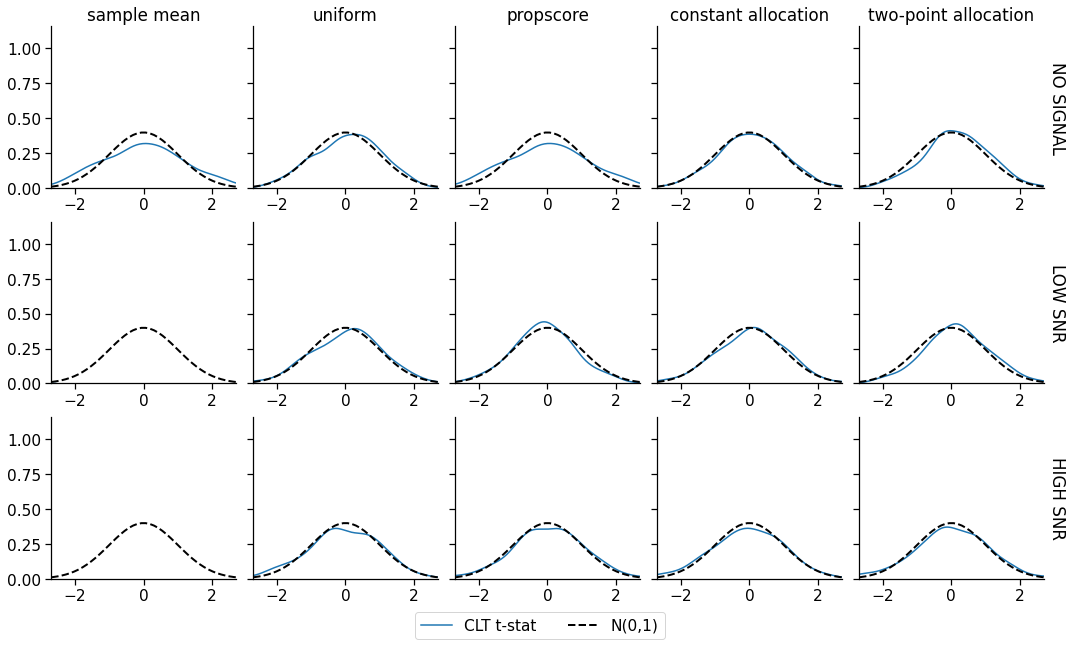

In [18]:
plot_hist(df.query("T == 100_000 and floor_decay == 0.7 and policy == '(0,2)'"))

In [19]:
df1 = df.query("T == 100_000 and floor_decay == 0.7")

In [20]:
df1.query("method == 'bernstein' and statistic == 't-stat' and policy == '(0,2)'")

statistic policy      value     method       T  K noise_func  noise_scale  \
13    t-stat  (0,2)  -8.578478  bernstein  100000  3    uniform          1.0   
13    t-stat  (0,2)  -3.376195  bernstein  100000  3    uniform          1.0   
13    t-stat  (0,2)  -3.728994  bernstein  100000  3    uniform          1.0   
13    t-stat  (0,2)  -3.962429  bernstein  100000  3    uniform          1.0   
13    t-stat  (0,2) -10.393869  bernstein  100000  3    uniform          1.0   
..       ...    ...        ...        ...     ... ..        ...          ...   
13    t-stat  (0,2)  -1.210763  bernstein  100000  3    uniform          1.0   
13    t-stat  (0,2) -10.517100  bernstein  100000  3    uniform          1.0   
13    t-stat  (0,2)  -5.212551  bernstein  100000  3    uniform          1.0   
13    t-stat  (0,2)  -1.097722  bernstein  100000  3    uniform          1.0   
13    t-stat  (0,2)   0.836997  bernstein  100000  3    uniform          1.0   

    floor_start  floor_decay  initial       dgp  
13     0.333333          0.7        5   highSNR  
13     0.333333          0.7        5    lowSNR  
13     0.333333          0.7        5    lowSNR  
13     0.333333          0.7        5    lowSNR  
13     0.333333          0.7        5   highSNR  
..          ...          ...      ...       ...  
13     0.333333          0.7        5  nosignal  
13     0.333333          0.7        5   highSNR  
13     0.333333          0.7        5    lowSNR  
13     0.333333          0.7        5  nosignal  
13     0.333333          0.7        5  nosignal  

[1115 rows x 12 columns]

In [9]:
def plot_wdecorr_comparison(df):
    """
    Compare W-decorrelation and two-point allocation rate. Plot RMSE and 90% coverage of t-stat of good arm high SNR, bad arm high SNR and arms no signal.
    """
    hue_order = ['W-decorrelation_15', 'two_point']
    palette = sns.color_palette("muted")[:len(hue_order)]
    col_order = ['highSNR:0', 'highSNR:2', 'nosignal:0']

    df_subset = df.query('method == @hue_order')
    df_subset['experiment_policy'] = df_subset['dgp'] + ":" + df_subset['policy'].astype(str)

    g = sns.catplot(x="T",
                    y="value",
                    hue='method',
                    hue_order=hue_order,
                    palette=palette,
                    col="experiment_policy",
                    col_order=col_order,
                    row="statistic",
                    row_order=['mse', 'CI_width', '90% coverage of t-stat'],
                    kind="point",
                    sharex=True,
                    sharey='row',
                    legend=False,
                    legend_out=True,
                    margin_titles=True,
                    data=df_subset)


    # plot RMSE of good arm high SNR
    for i, col in enumerate(col_order): # good arm, bad arm, bad(any) arm
        g.axes[0, i].clear()
        sns.pointplot(x='T',
                      y="value",
                      hue='method',
                      hue_order=hue_order,
                      palette=palette,
                      ax=g.axes[0, i],
                      data=df_subset.query(f"statistic=='mse' & experiment_policy == @col"),
                      estimator=lambda x: np.sqrt(np.mean(x)))
        g.axes[0, i].get_legend().remove()
        g.axes[0, i].set_xlabel("")
        g.axes[0, i].set_ylabel("")


    # Add row and column names
    g.row_names = ['RMSE', 'Confidence Interval Radius', '90% coverage of t-stat']
    g.col_names = ['GOOD ARM: HIGH SIGNAL', 'BAD ARM: HIGH SIGNAL', 'NO SIGNAL']


    for ax in g.axes.flat:
        plt.setp(ax.texts, text="")

    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    # rmse
    for ax in g.axes[0, :]:
        ax.axhline(0., color="black", linestyle='--')
    
    # ci radius
    for ax in g.axes[1, :]:
        ax.axhline(0., color="black", linestyle='--')
    
    # coverage
    for ax in g.axes[2, :]:
        ax.axhline(.9, color="black", linestyle='--')

    # Add legend
    handles, labels = g._legend_data.values(), g._legend_data.keys()
    g.fig.legend(labels=['W-decorrelation', 'Two-point allocation'],
                 handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.0))

    g.set_xlabels("Experiment length")
    g.set_ylabels("")

    g.fig.tight_layout()
    g.fig.subplots_adjust(bottom=0.1)
    
    return g.fig

In [10]:
def plot_lambda(df_lambdas, save=False):
    """
    Plot lambda(T-t) for stablevar-typed weights.
    """
    assert df_lambdas['T'].nunique() == 1
    save = False
    g = sns.relplot(x="time",
                    y="value",
                    col="dgp",
                    col_order=[f'nosignal', f'lowSNR', f'highSNR'],
                    kind="line",
                    row='policy',
                    row_order=[2, 0],
                    facet_kws=dict(
                        sharex=False,
                        sharey=False),
                    legend=False,
                    ci=None,
                     data=df_lambdas)

    g.col_names = ['NO SIGNAL', 'LOW SIGNAL', 'HIGH SIGNAL']
    g.row_names = ['GOOD ARM', 'BAD ARM']

    Tmax = df_lambdas['T'].max()
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="")
        ax.set_yscale('log')
        xticks = ax.get_xticks()
        ax.set_xticks([0, xticks[len(xticks)//2], xticks[-1]])
        ax.axhline(1.0, color="black", linestyle='--')
        ax.set_xticklabels([0, Tmax//2, Tmax])
    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    g.set_xlabels("")
    g.set_ylabels("")

    g.fig.tight_layout()
    if save:
        plt.savefig(f'figures/lambda.pdf', bbox_inches='tight')
        plt.show()

----

### Load data

In [11]:
commit = ""

In [21]:
stats_files = glob(f"results/stats*{commit}*.pkl")
print(f"Found {len(stats_files)} files associated with statistics.")

dfs = []
for k, file in enumerate(stats_files):
    if k % 200 == 0:
        print(f"Reading file {k}.")
    try:
        dfs.append(pd.read_pickle(file))
    except Exception as e:
        print(f"Error when reading file {file}.")
        
print(f"Loaded {len(dfs)} files.")
df = pd.concat(dfs)
df['value'] = df['value'].astype(float)
decay_rates = np.sort(df['floor_decay'].unique())
df.shape

Found 42 files associated with statistics.
Reading file 0.
Loaded 42 files.


(3074400, 12)

In [22]:
lambda_files = glob(f"results/lambdas*{commit}*.pkl")
print(f"Found {len(lambda_files)} files associated with lambda values.")

dfs = []
for k, file in enumerate(lambda_files[:20]):
    if k % 5 == 0:
        print(f"Reading file {k}.")
    try:
        dfs.append(pd.read_pickle(file))
    except Exception as e:
        print(f"Error when reading file {file}.")
        
print(f"Loaded {len(dfs)} files.")
df_lambdas = pd.concat(dfs)
df_lambdas['value'] = df_lambdas['value'].astype(float)
df_lambdas['time'] = df_lambdas['time'].astype(float)
df_lambdas.shape

Found 42 files associated with lambda values.
Reading file 0.
Reading file 5.
Reading file 10.
Reading file 15.
Loaded 20 files.


(1023000, 11)

----

# Arm values at large T

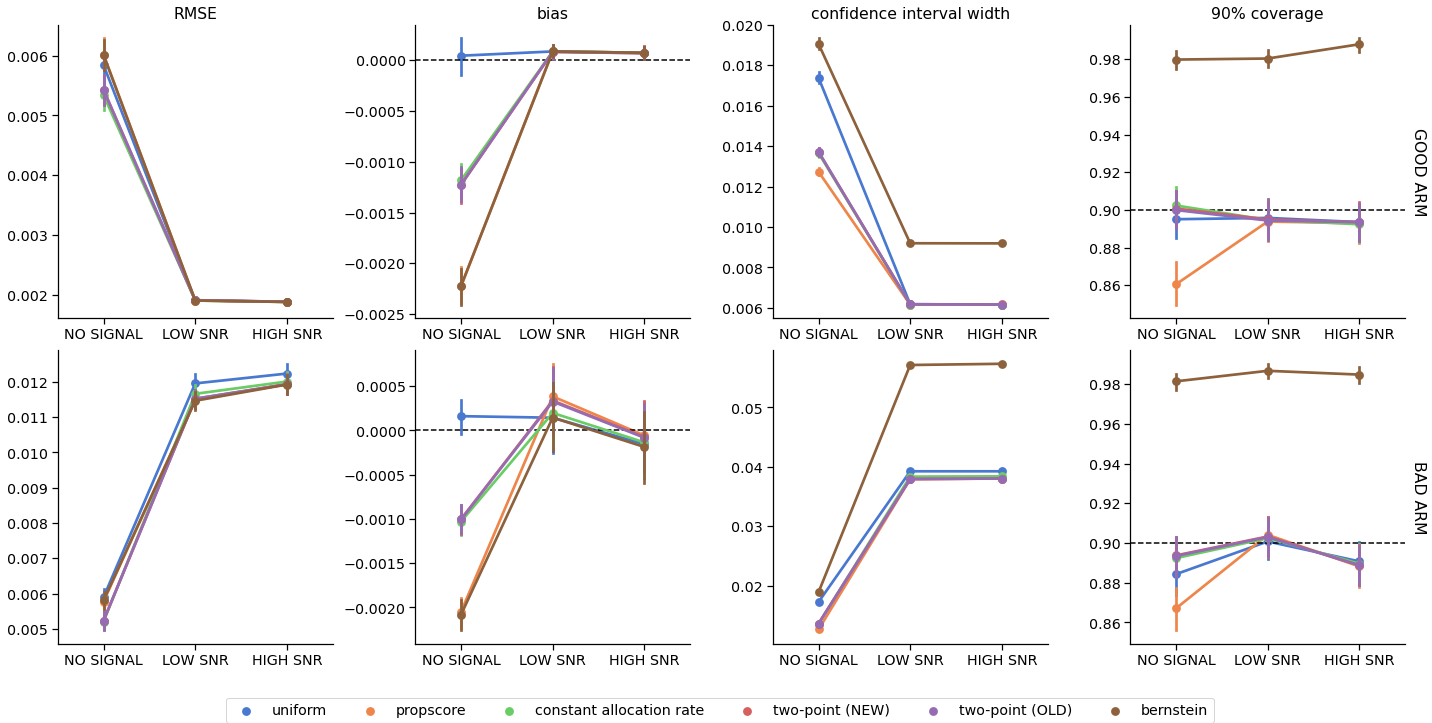

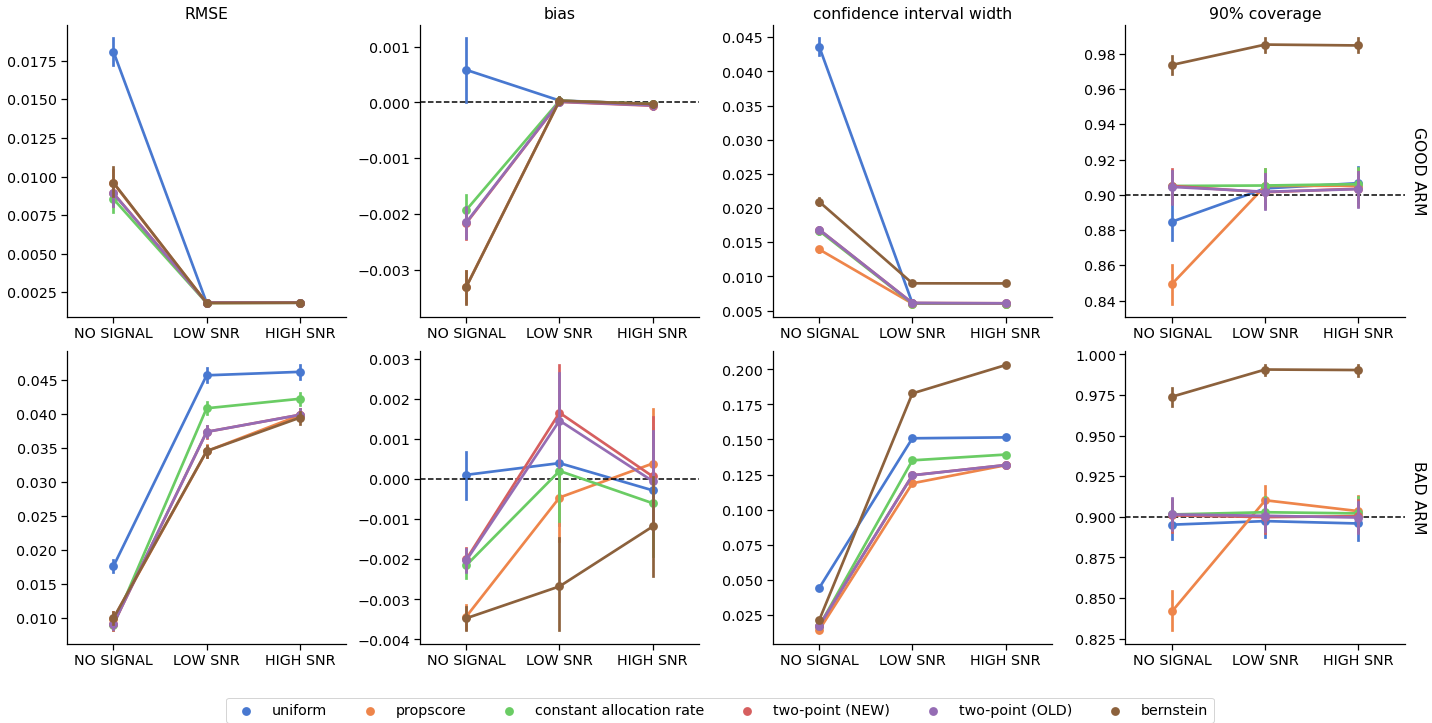

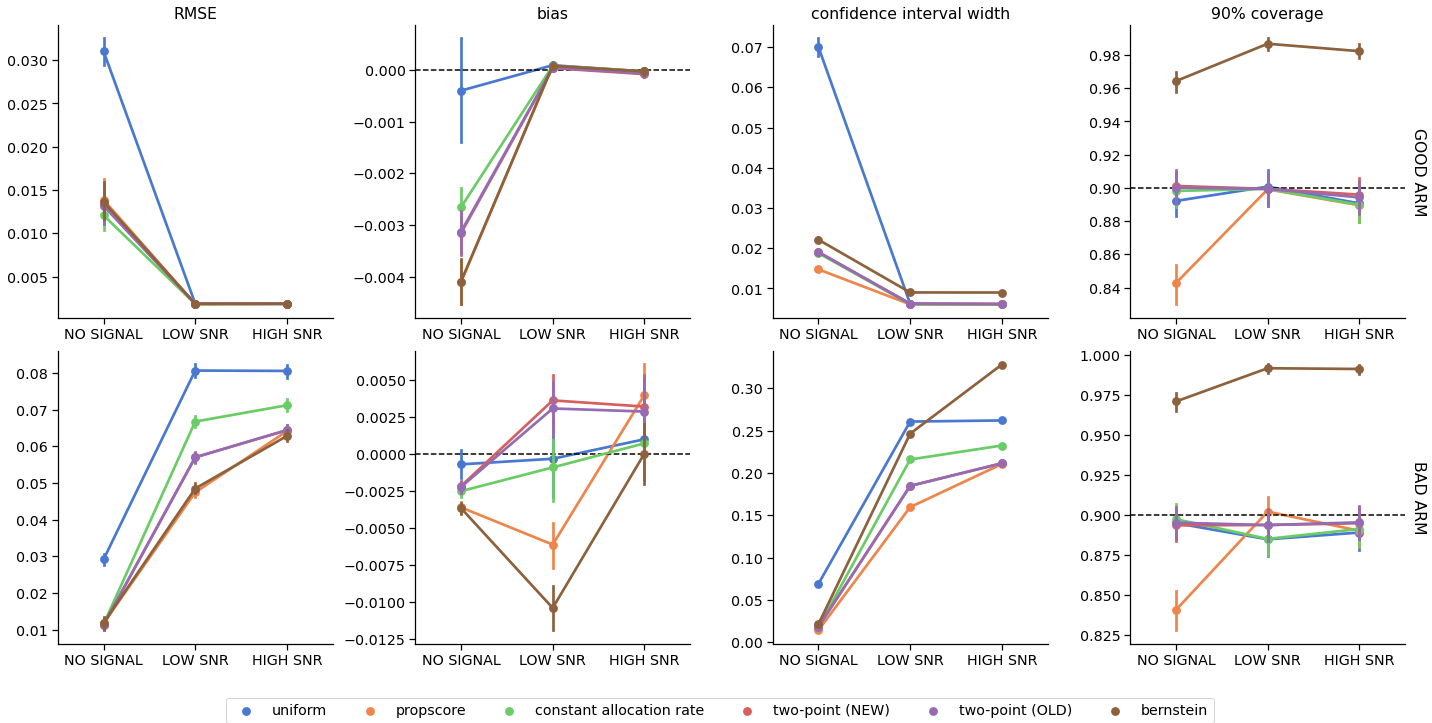

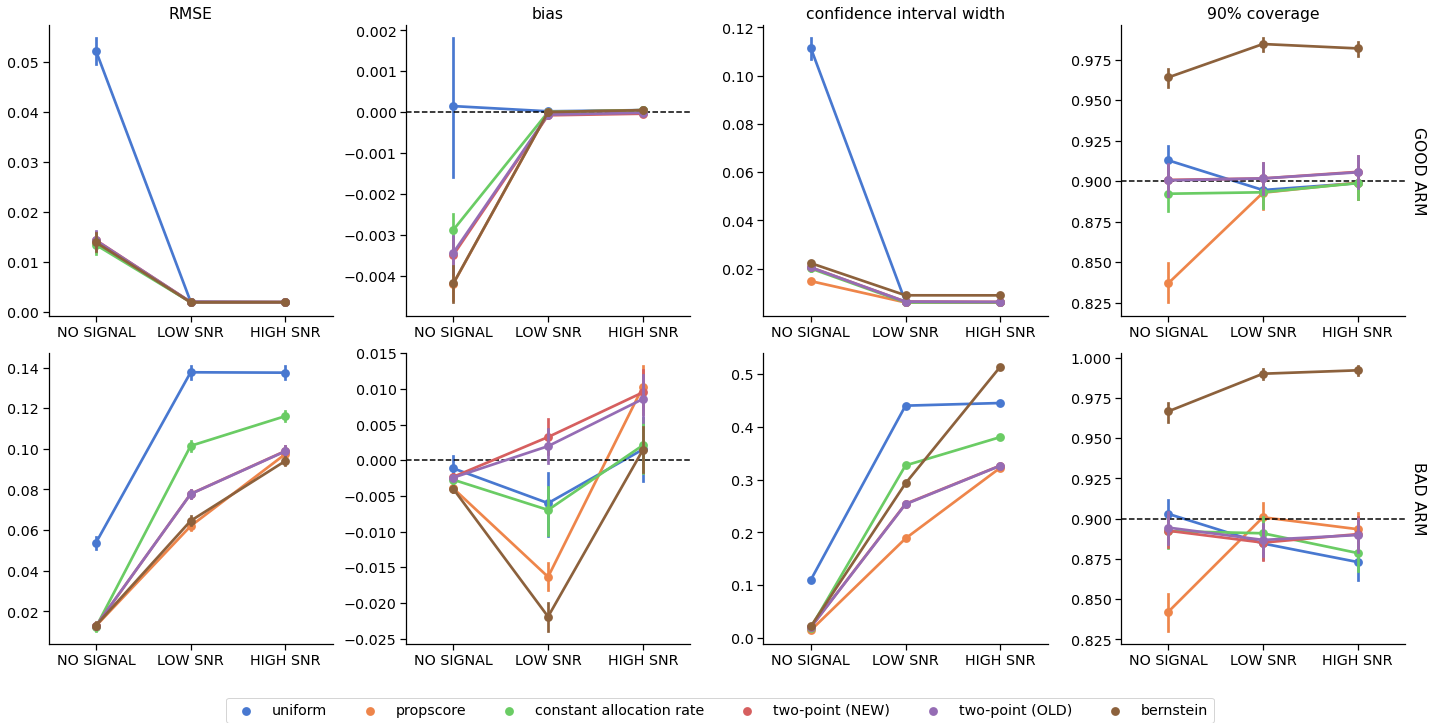

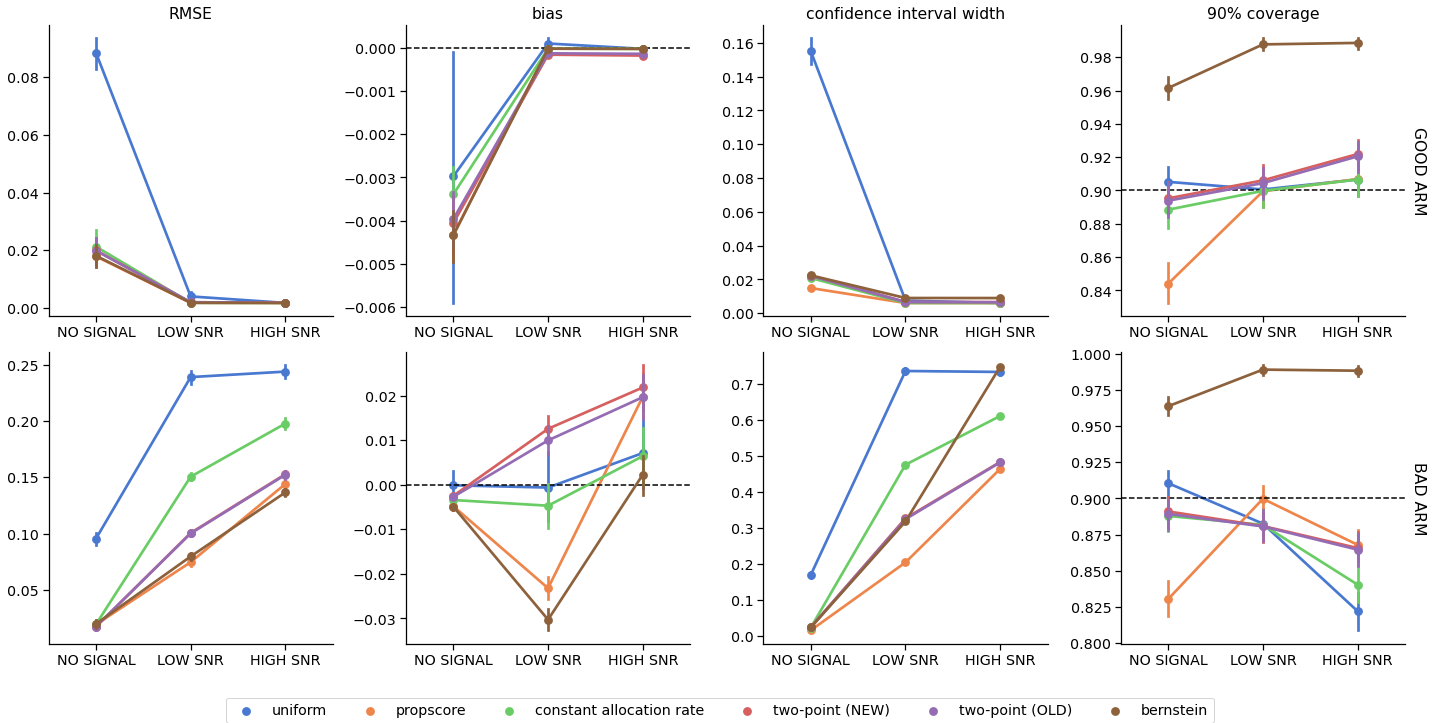

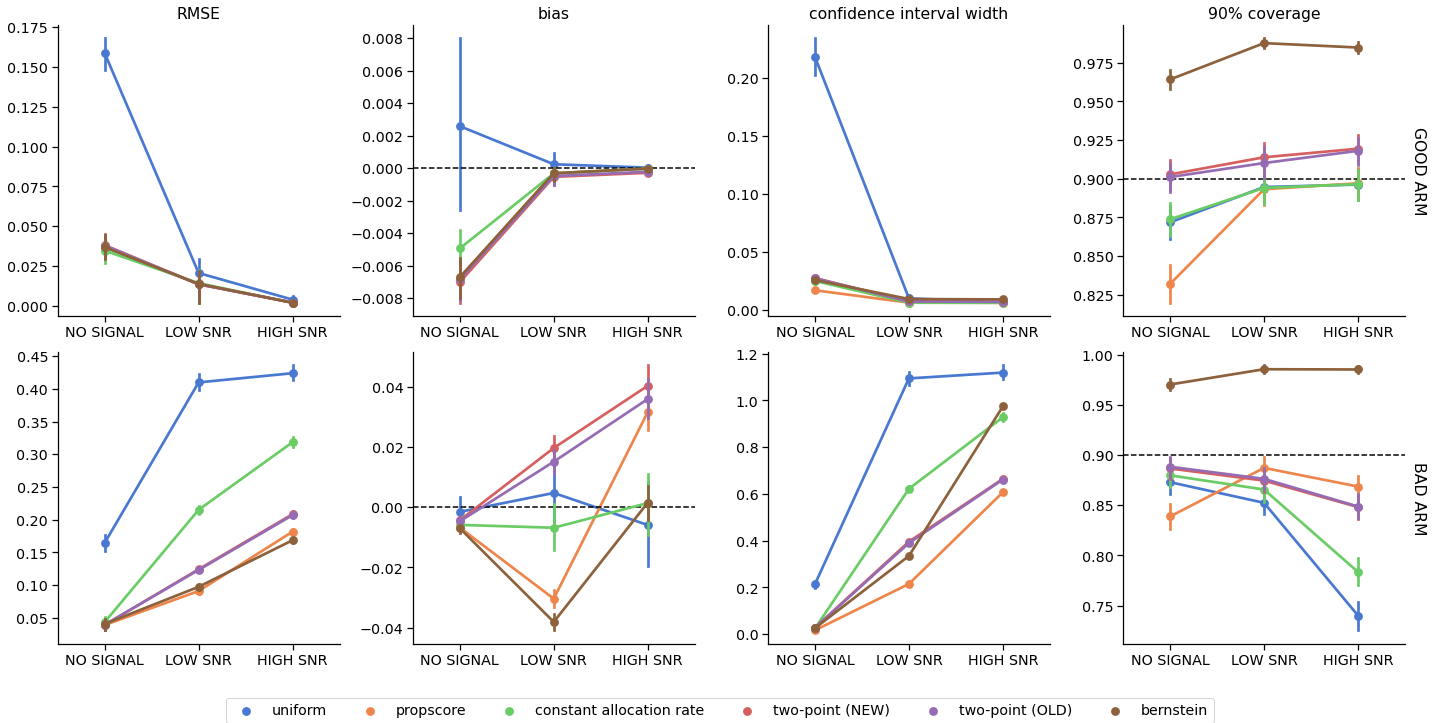

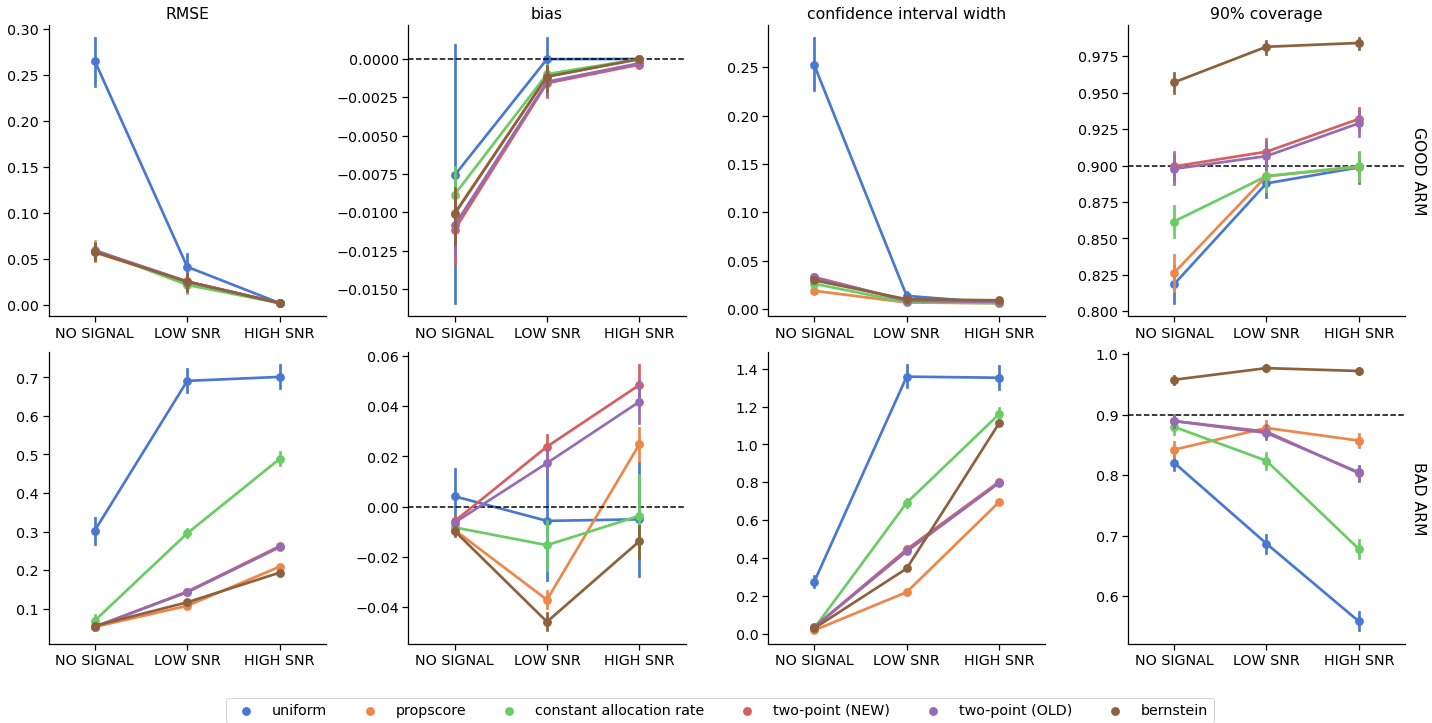

In [109]:
for alpha in decay_rates:
    display(HTML(f"<h2>Decay rate (alpha) = {alpha}</h2>"))
    plot_converged_statistics2(df.query(f"floor_decay=={alpha} & T == 100_000"))

---

# Contrasts

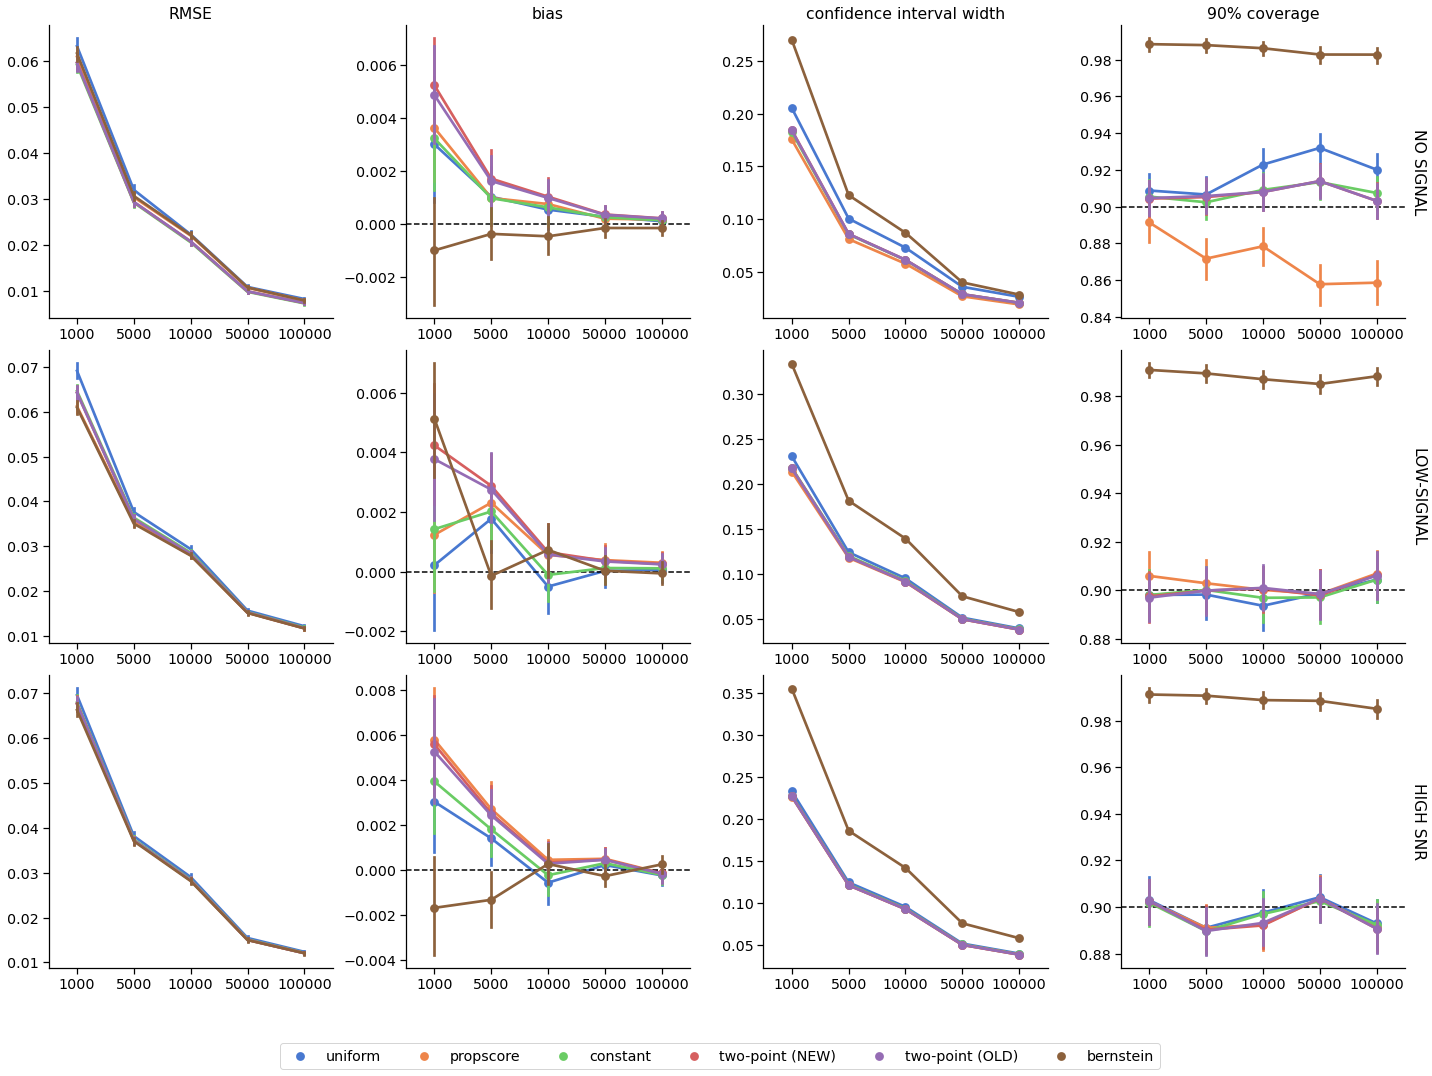

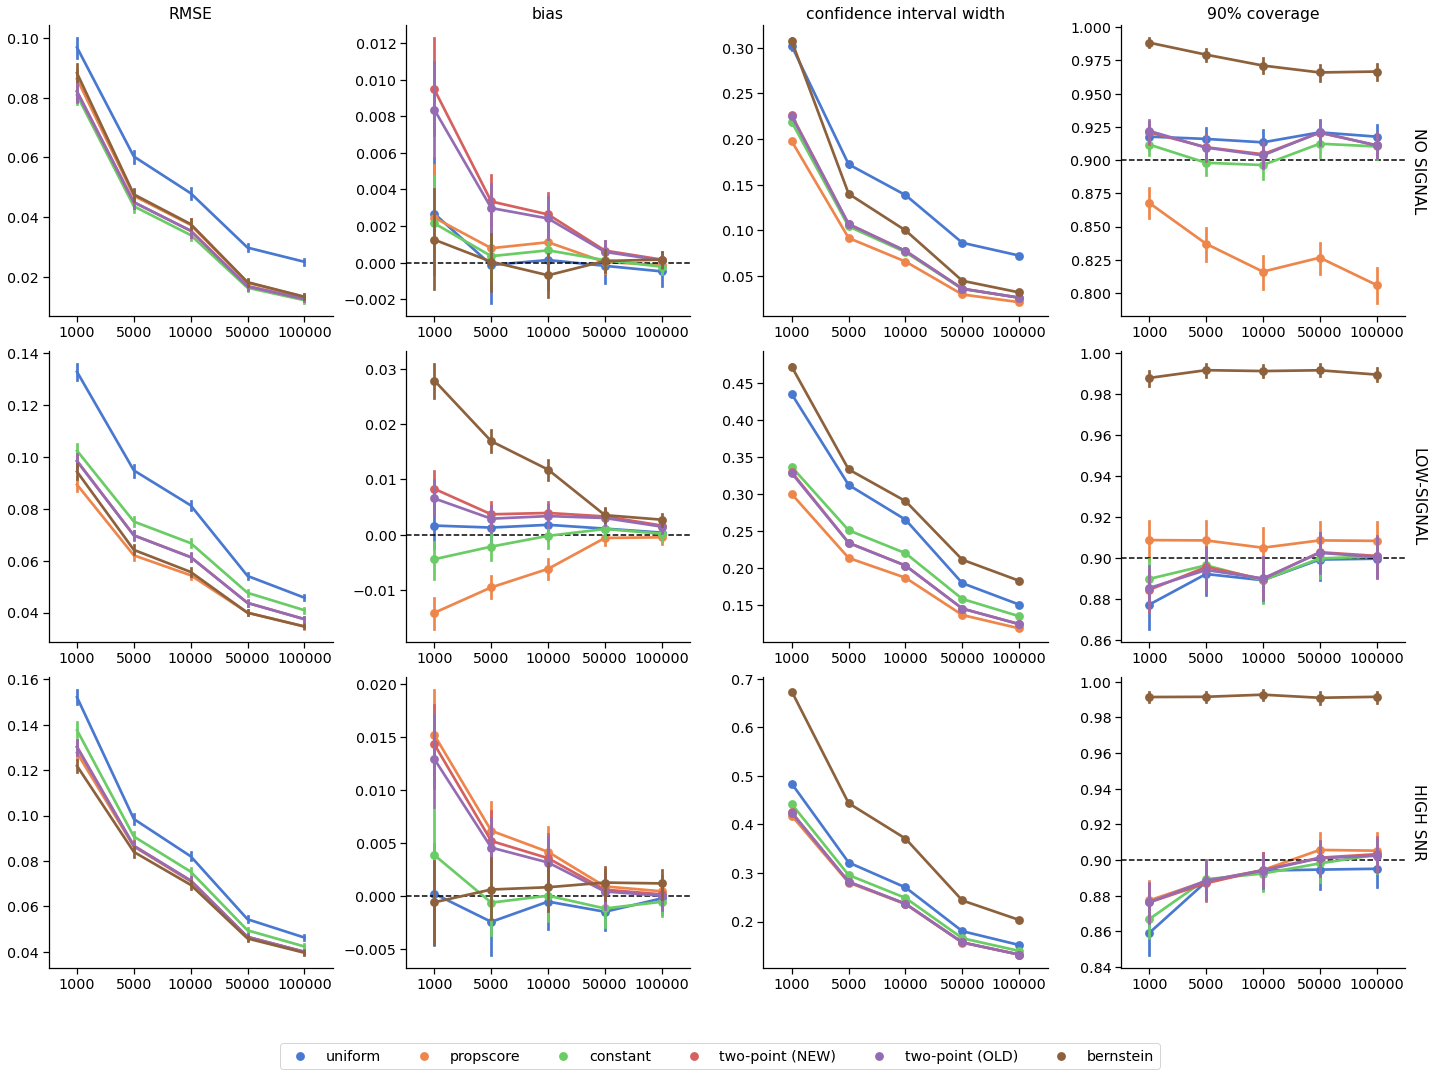

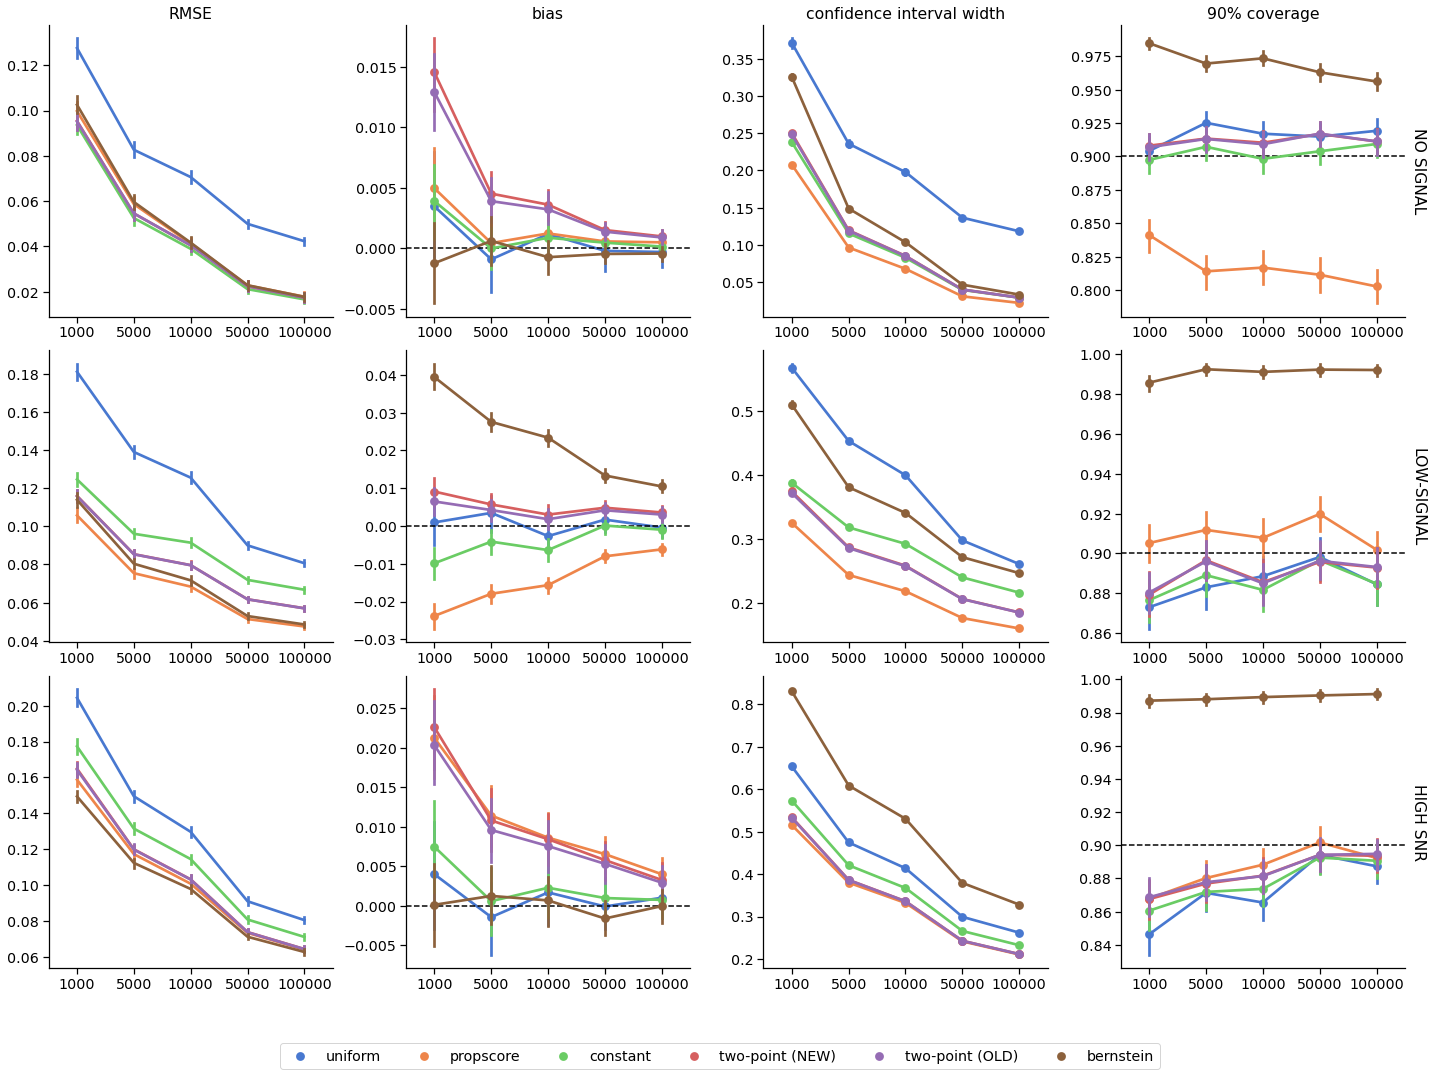

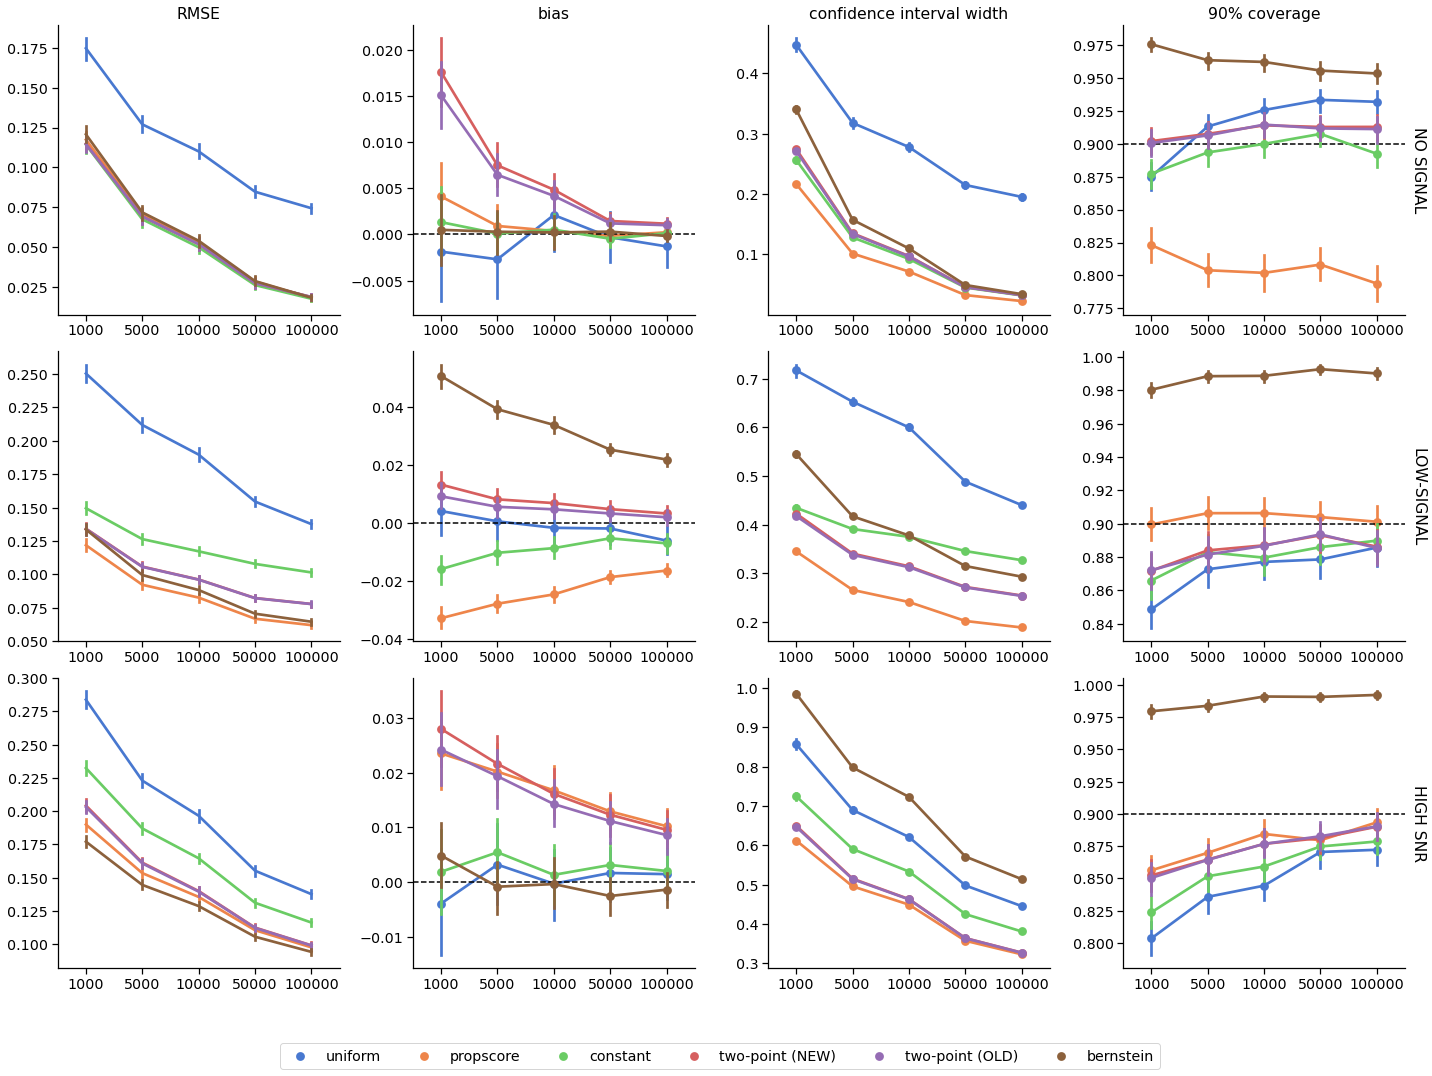

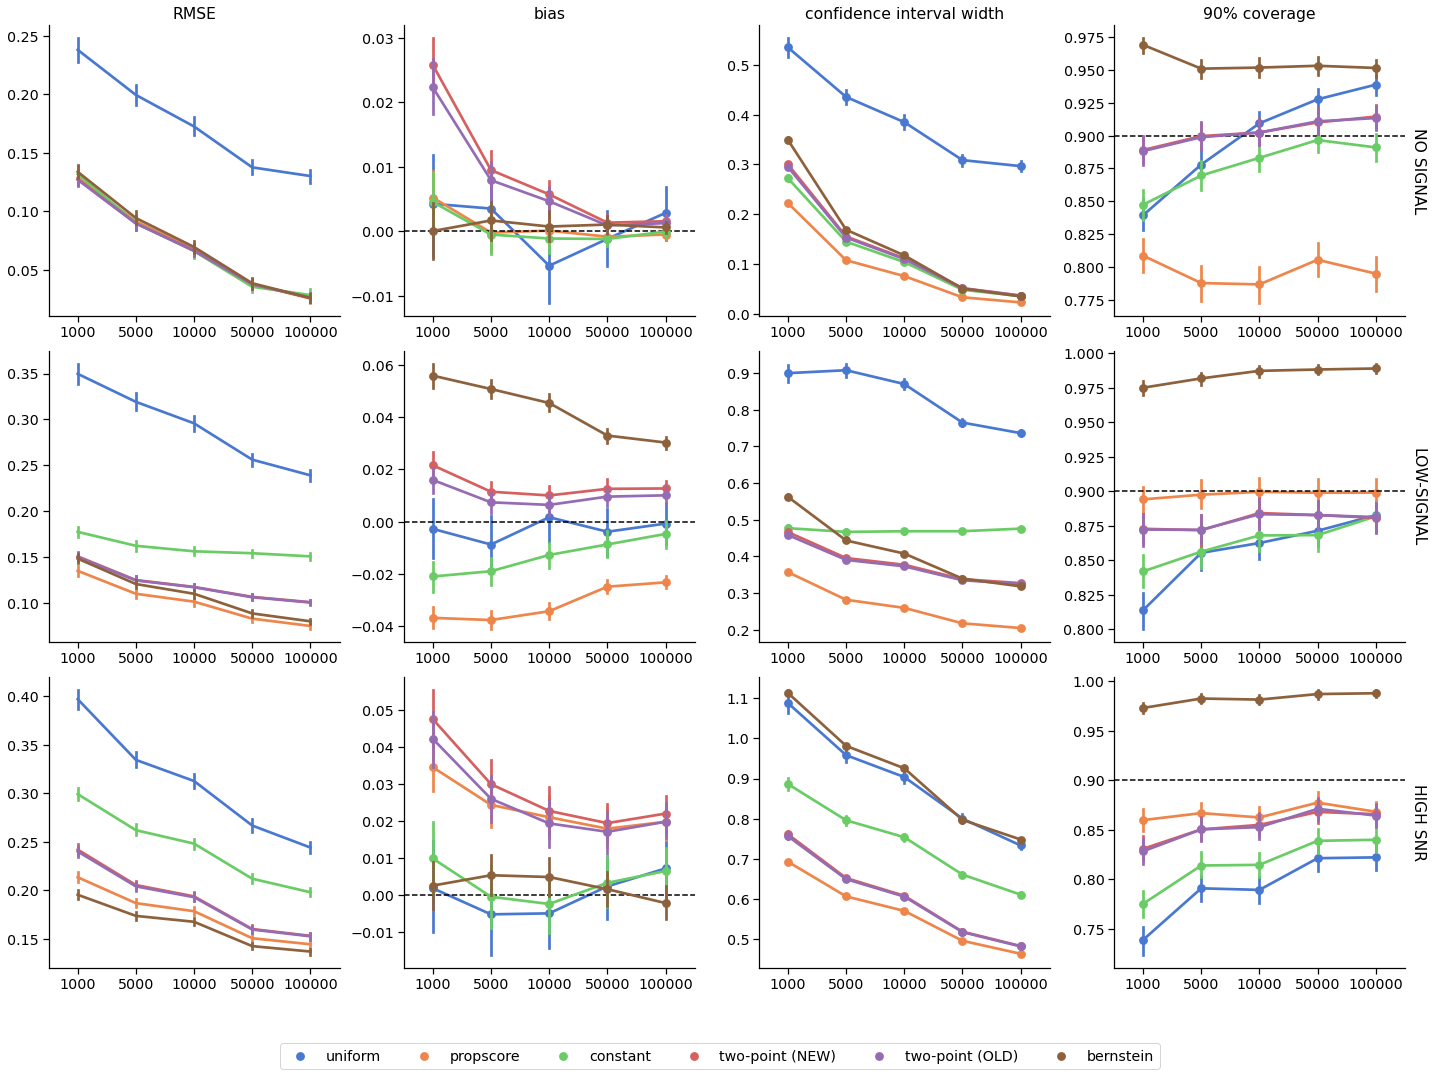

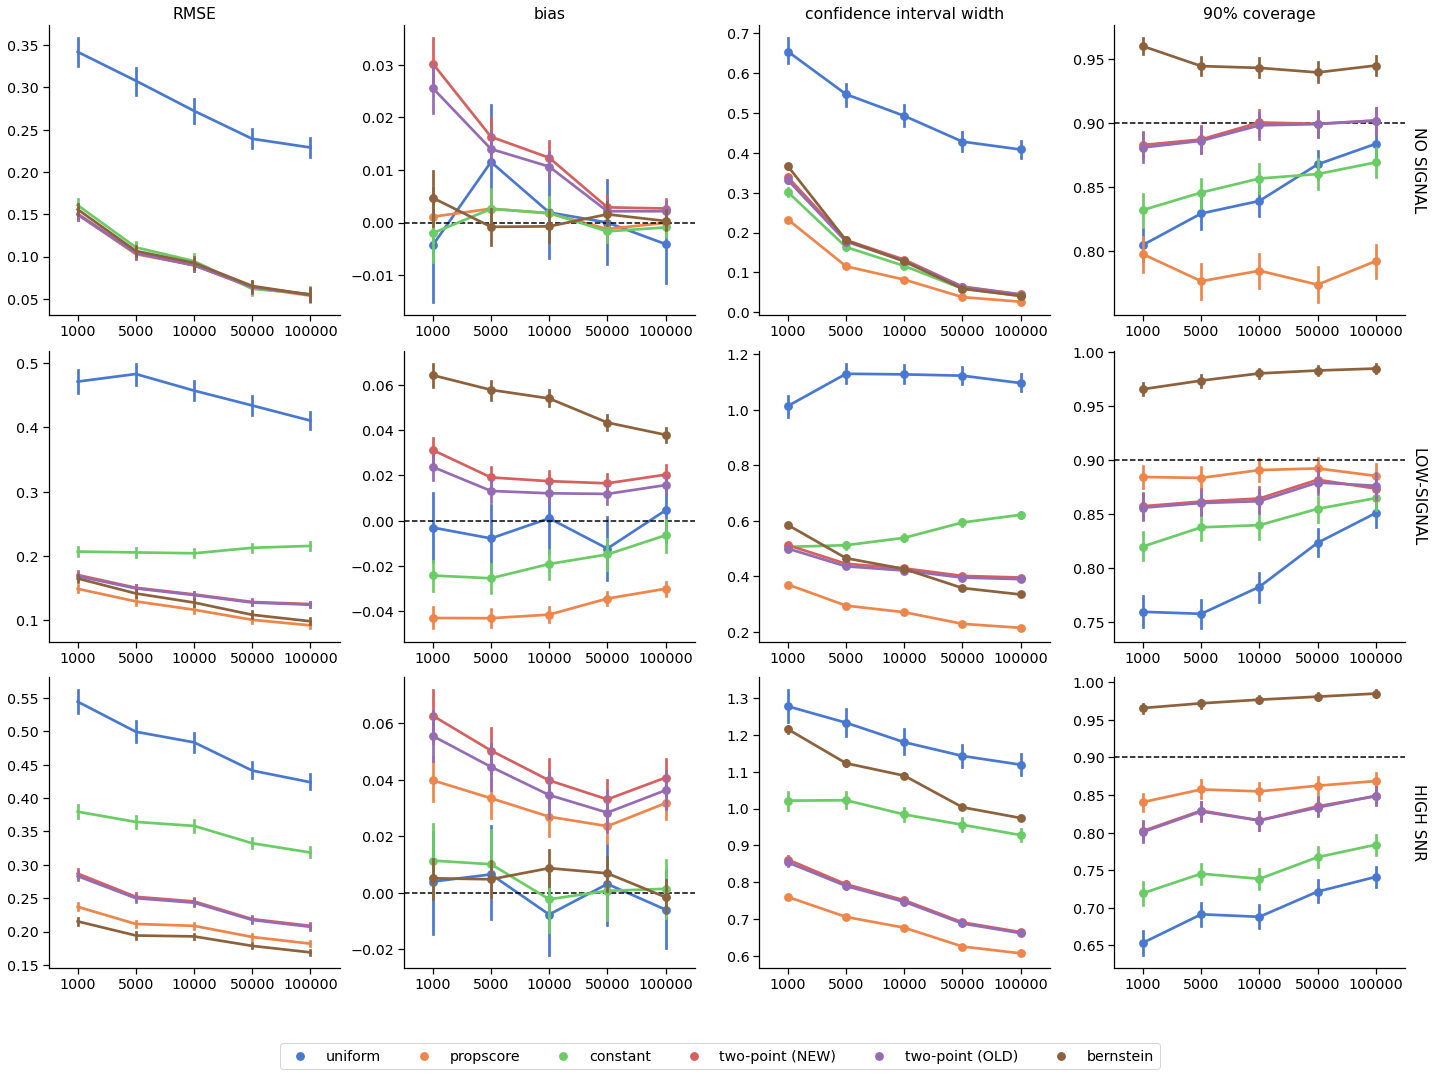

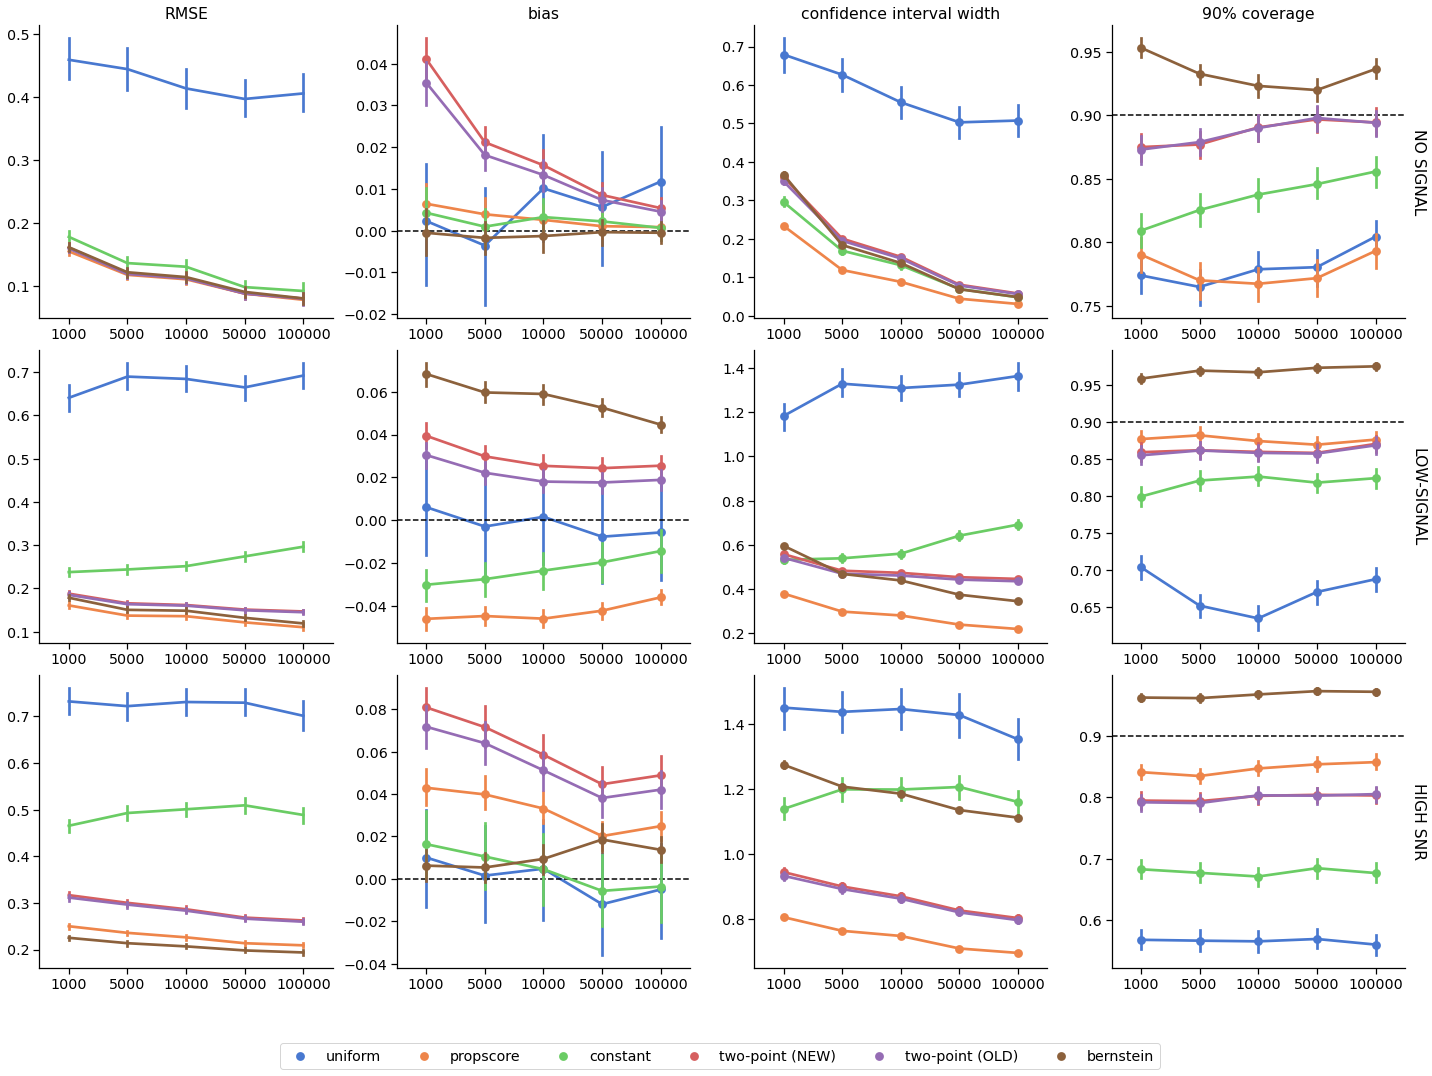

In [110]:
for alpha in decay_rates:
    display(HTML(f"<h2>Decay rate (alpha) = {alpha}</h2>"))
    plot_contrast(df.query(f"policy=='(0,2)' and floor_decay=={alpha}"))

-----

# Figures that will actually go in the paper

In [23]:
alpha = 0.7

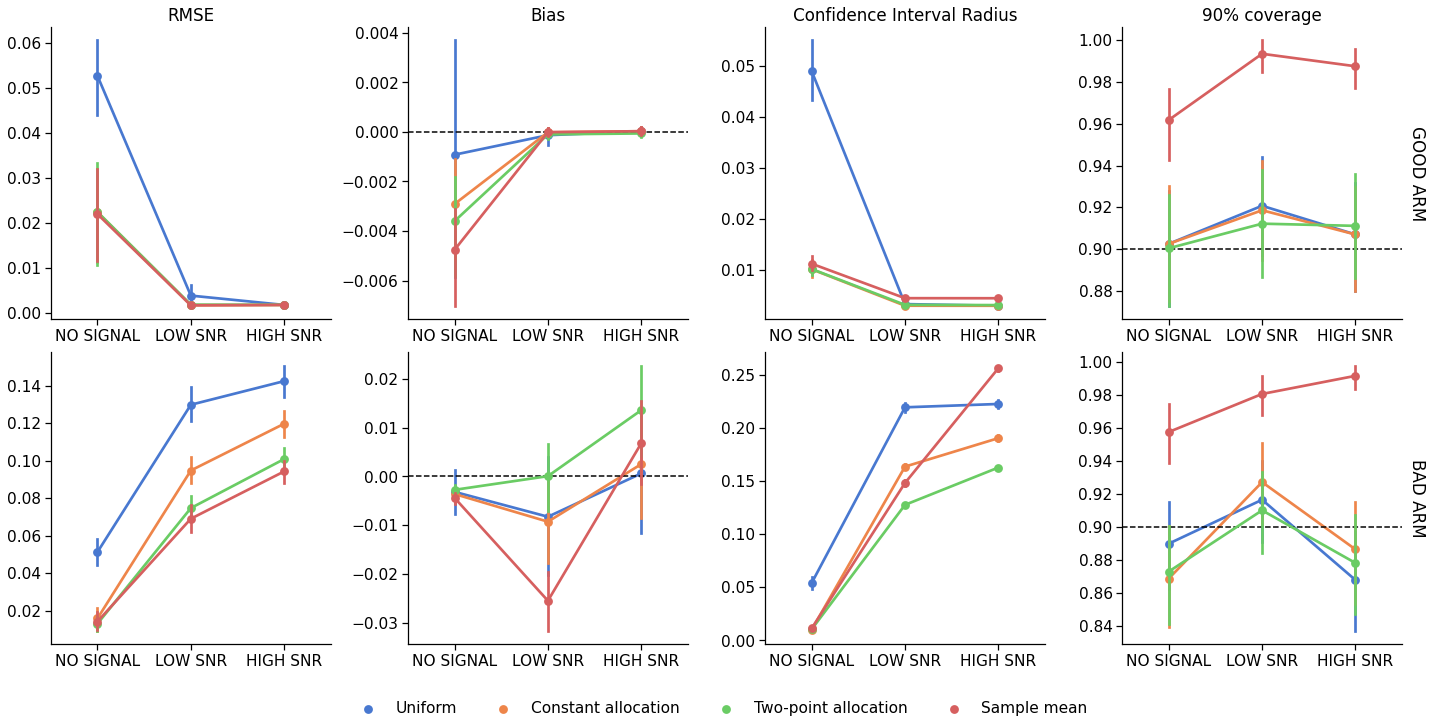

In [24]:
plot_arm_values(
    df.query(f"T == 100_000 and floor_decay == {alpha}"),
    hue_order=['uniform',  'lvdl', 'two_point', 'bernstein'], 
    labels=['Uniform', 'Constant allocation', 'Two-point allocation', 'Sample mean'],
    name="arm_values")

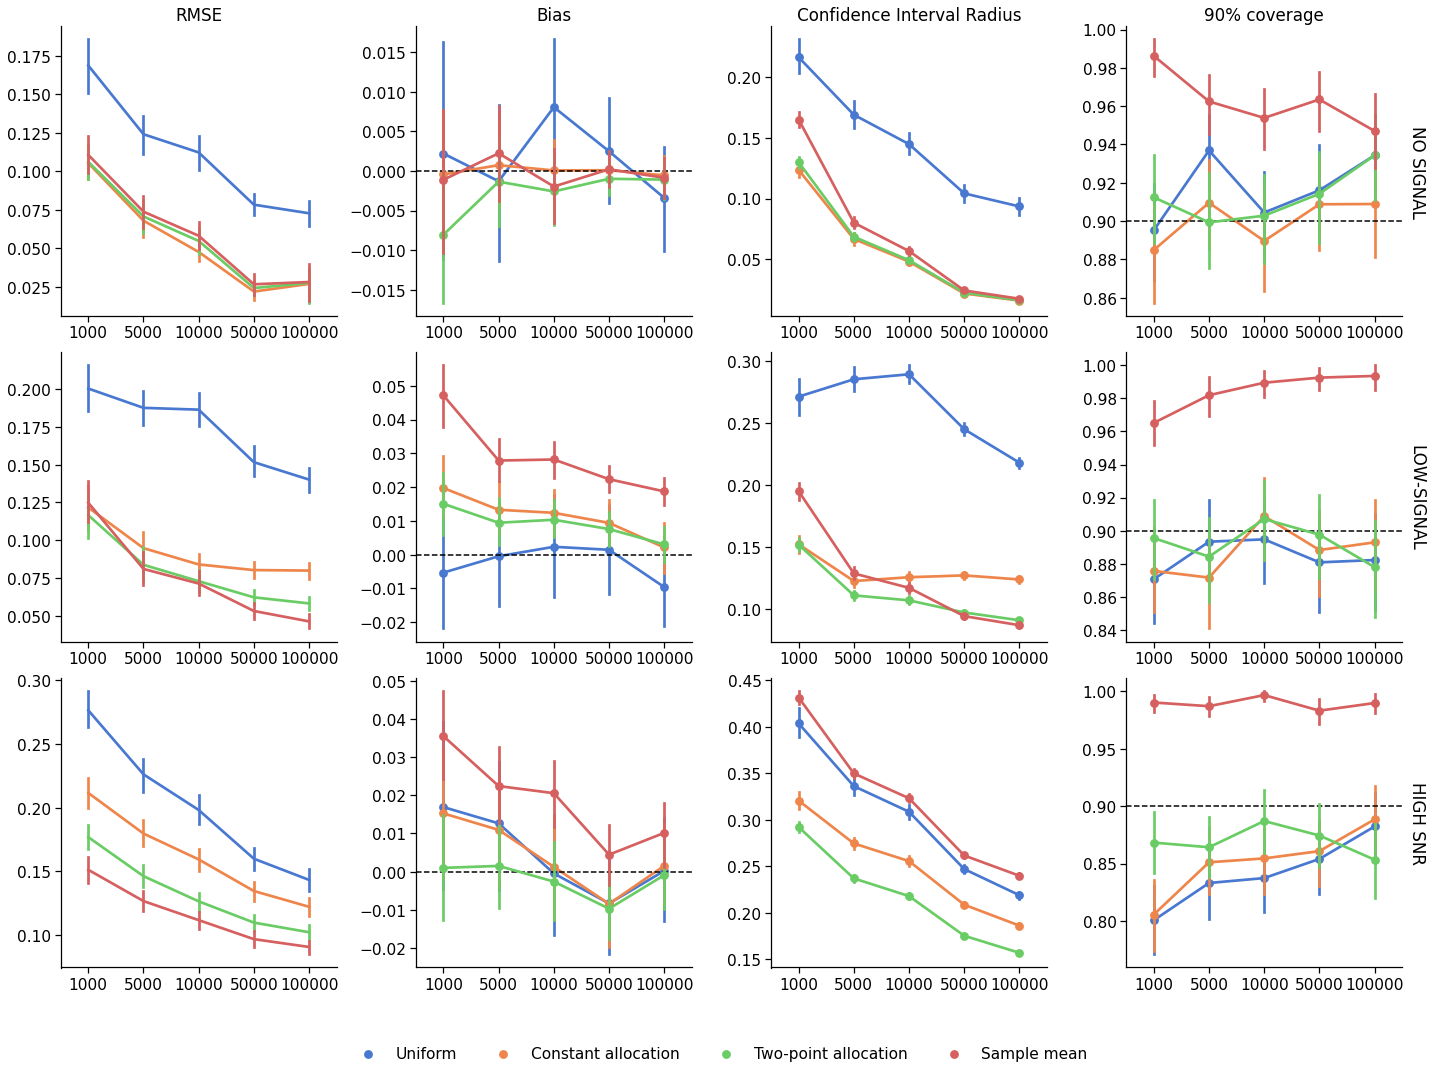

In [25]:
plot_contrast(df.query(f"policy=='(0,2)' and floor_decay=={alpha}"),
              hue_order=['uniform',  'lvdl', 'two_point', 'bernstein'], 
              col_names=['RMSE', 'Bias', 'Confidence Interval Radius', '90% coverage'],
              labels=['Uniform', 'Constant allocation', 'Two-point allocation', 'Sample mean'],
              name="contrast")

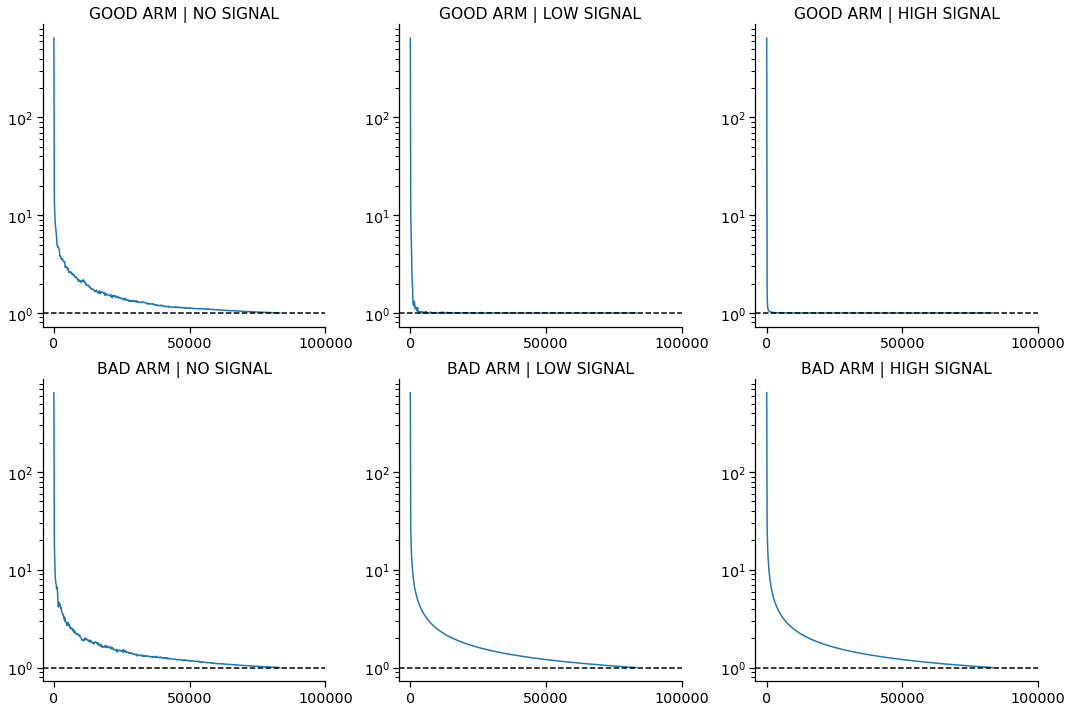

In [16]:
plot_lambda(df_lambdas.query(f"T == 100_000 and floor_decay == {alpha}"), save="lambdas")

/Users/vitorhadad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


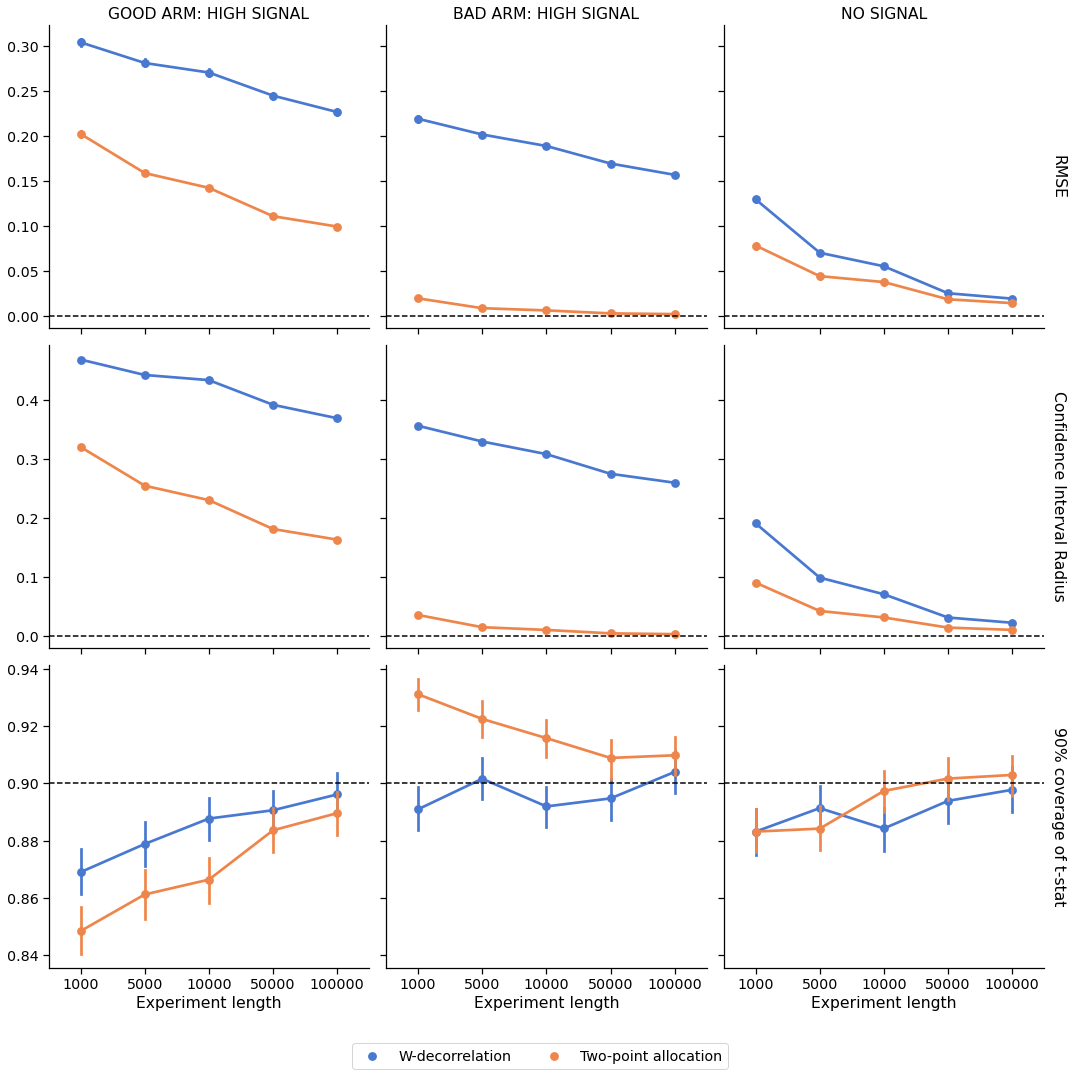

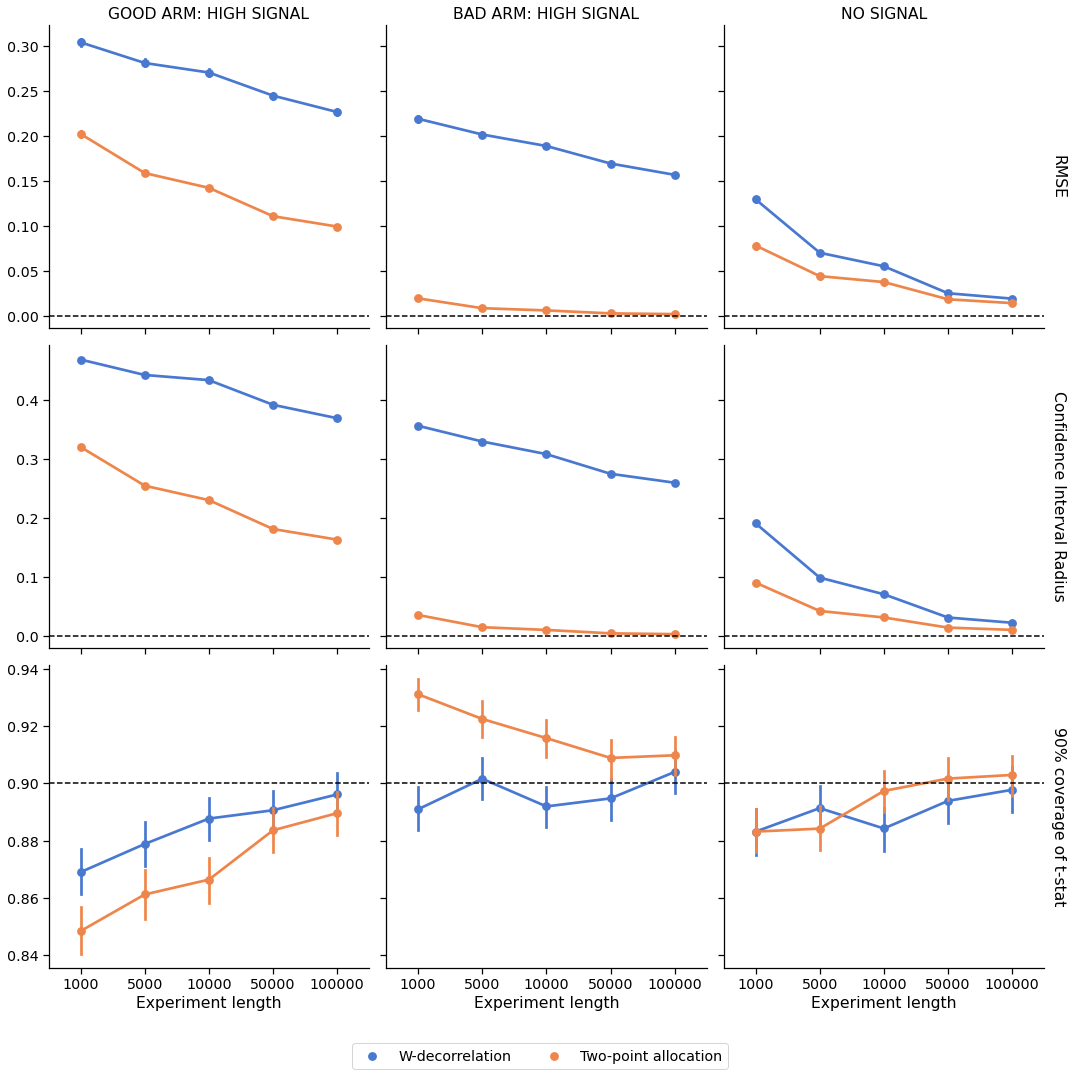

In [52]:
compare_with_wdecorr(df.query(f"floor_decay == {alpha}"))

In [ ]:
plot_hist(df)